In [1]:
# Torch version
!python -c "import torch; print(torch.__version__)"

# Cuda version
!python -c "import torch; print(torch.version.cuda)"

2.6.0+cu124
12.4


In [2]:
# Uninstall
# !pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib -y

In [3]:
# Update Torch
# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

In [4]:
# Install PyG (automatic)
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch_geometric

In [5]:
# Verify instalation
import torch
import torch_geometric
import torch_scatter

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch_scatter.__version__)
print(torch_geometric.__version__)


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.6.0+cu124
12.4
True
2.1.2+pt26cu124
2.7.0


In [6]:
from model_PyG import *
from utils import *

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [8]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


In [9]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_attr))

### Setup

In [10]:
dataset = "mentos_05" # "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
encoder = "GIN" # Change GIN, GINE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load("data/ACM-DBLP.npz")
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b["test_pairs"].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 1e-4 # 1e-4
	epochs = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512, 512, 512, 512, 512, 512, 512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epochs = 100
elif (dataset == "mentos_05"):
	train_set = [
		# "Orange_1", "Orange_2",
		"Red_1", "Red_2",
		# "Yellow_1", "Yellow_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 16
	lr = 0.0001
	epochs = 100
elif (dataset == "vanessa_05"):
	train_set = [
		"FrescoAmazonas_1", "FrescoAmazonas_2",
		# "FrescoCusco_1", "FrescoCusco_2",
		# "FrescoSanMartin_1", "FrescoSanMartin_2",
		# "SecoAmazonas_1", "SecoAmazonas_2",
		# "SecoCusco_1", "SecoCusco_2",
		# "SecoSanMartin_1", "SecoSanMartin_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 150

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3],
	[3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)
edge_attr = torch.tensor([
	[0.5, 1.0], 
	[0.5, 1.0], 
	[1.0, 1.5], 
	[1.0, 1.5]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)

print(data)
info(data)

transform = T.Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
	T.ToDevice(device)
])

data = transform(data)
print(data)
info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [11]:
# Only for GIN
""" transform = Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
]) """

# For GIN and GINE
transform = T.Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
	T.ToDevice(device)
])

In [12]:
print("Loading training datasets")

train_loader = {}
# scaler = StandardScaler()

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling
		
		""" if i==1:
			x = x[torch.randperm(x.size(0))] # permutations for test """

		edge_attr = torch.ones((edge_index.size(1), 1)) # Only for test GINE

		data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
		info(data)

		data = transform(data)
		train_loader[ts] = data
		info(data)
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	train_loader[train_set[0]] = data1
	info(data1)

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	train_loader[train_set[1]] = data2
	info(data2)
elif dataset in ["vanessa_05", "mentos_05"]: # Change
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx, id, mz, rt, 0, 1, 2, ...

		df_intensity = df_nodes.iloc[:, 4:]
		# 0, 1, 2, ...

		df_edges = pd.read_csv("data/{}/edges_{}.csv".format(dataset, ts))
		# source, target, weight, subgroup

		# Node features
		mz = np.log10(df_nodes["mz"].values + 1e-8) # Log-transform m/z to stabilize scale differences
		rt = df_nodes["rt"].values
		rt = (rt - rt.mean()) / (rt.std() + 1e-8) # Z-score normalization for retention time (RT)

		intensity = df_intensity.values.astype(np.float32)
		intensity = intensity / (intensity.sum(axis=0, keepdims=True) + 1e-8)
		mean_intensity = intensity.mean(axis=1)

		std_intensity = intensity.std(axis=1)
		cv = std_intensity / (mean_intensity + 1e-8)
		# cv = np.log1p(np.clip(cv, 0, 2.0))

		presence_ratio = (df_intensity.values > 0).sum(axis=1) # / df_intensity.shape[1] # Fraction of samples where the feature is detected # Acts as a reliability / confidence signal

		x = np.stack([
				mz,             # physicochemical identity
				rt,             # chromatographic alignment
				mean_intensity, # global abundance
				std_intensity,
				cv,           	# robustness (anti-oversmoothing)
				presence_ratio  # reliability
			], axis=1)

		x = torch.tensor(x, dtype=torch.float) # [N, F]
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling

		# Edge index
		edge_index = torch.tensor(df_edges.iloc[:, [0, 1]].values.T, dtype=torch.long) # [2, E]

		# Edge attribute
		edge_weight = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float) # [E]

		# edge_attr = edge_weight.view(-1, 1) # [E,1]
		edge_attr = torch.stack([
							edge_weight.abs(),        # strength
							torch.sign(edge_weight),  # direction (+1, -1)
							edge_weight ** 2          # nonlinearity
						], dim=1) # [E, 3]

		# Reduce number of edges
		mask = torch.abs(edge_weight) > 0.95
		edge_index = edge_index[:, mask]
		edge_attr  = edge_attr[mask]

		data = Data(x=x, edge_index=edge_index.contiguous(), edge_attr=edge_attr)

		data = transform(data)
		# data = data.to(device)

		train_loader[ts] = data
		info(data)

		test_pairs = None # No use

Loading training datasets
Validate:	 True
Num. nodes:	 1777
Num. edges:	 663559
Num. features:	 6
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 1774, 1775, 1776],
        [   2,    6,   11,  ..., 1774, 1775, 1776]], device='cuda:0')
tensor([[ 1.8872e+00, -2.1626e+00,  3.1185e-06,  1.1013e-06,  3.5203e-01,
          3.0000e+00],
        [ 2.0378e+00, -2.1454e+00,  4.1764e-08,  2.0450e-08,  3.9507e-01,
          3.0000e+00],
        [ 1.7636e+00, -2.1379e+00,  5.6822e-07,  3.6560e-07,  6.3228e-01,
          3.0000e+00],
        ...,
        [ 1.9196e+00,  1.7690e+00,  7.9209e-07,  3.8133e-07,  4.7543e-01,
          3.0000e+00],
        [ 2.0216e+00,  1.7732e+00,  1.1962e-06,  4.0319e-07,  3.3428e-01,
          3.0000e+00],
        [ 2.3582e+00,  1.7774e+00,  1.0191e-07,  6.9386e-08,  6.2004e-01,
          3.0000e+00]], device='cuda:0')
tensor([[ 0.9682, -1.0000,  0.9375],
        [ 0.9701,  1.0000,  0.9412],
        [ 0.99

In [13]:
train_loader

{'Red_1': Data(x=[1777, 6], edge_index=[2, 663559], edge_attr=[663559, 3]),
 'Red_2': Data(x=[1772, 6], edge_index=[2, 692296], edge_attr=[692296, 3])}

### Train

In [14]:
def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

In [15]:
def fit_TGAE_subgraph(encoder, dataset, no_samples, model, epochs, train_loader, lr, test_pairs=None):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-4 # 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for ts in random.sample(train_set, k=len(train_set)): # shuffle train_set
			data = train_loader[ts]

			# Encoder
			if encoder == "GIN":
				z = model(data.x, data.edge_index)
				# z = F.normalize(z, dim=1)
			elif encoder == "GINE":
				z = model(data.x, data.edge_index, data.edge_attr)

			# Positive edges
			pos_edge_index = data.edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=data.edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)

			# option 2 Negative edges (dynamic)
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			# option 1
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
			
			# option 2
			""" pos_logits = F.cosine_similarity(
				z[pos_edge_index[0]],
				z[pos_edge_index[1]],
				dim=1
			)
			neg_logits = F.cosine_similarity(
				z[neg_edge_index[0]],
				z[neg_edge_index[1]],
				dim=1
			) """

			# Loss
			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# option 1
			""" loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)
			loss += loss_pos + loss_neg """

			# option 2
			# num_pos = pos_edge_index.size(1)
			# num_neg = neg_edge_index.size(1)
			# pos_weight = torch.tensor([num_neg / num_pos], device=device)
			logits = torch.cat([pos_logits, neg_logits], dim=0)
			labels = torch.cat([pos_labels, neg_labels], dim=0)
			loss_temp = F.binary_cross_entropy_with_logits(logits, labels) #, pos_weight=pos_weight) # with pos_weight
			loss += loss_temp
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

		# Evaluation (for firts dataset)
		""" model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()
			
			# Similarity matrix
			# option 1
			D = torch.cdist(z1, z2, 2)

			# option 2 (GPU problem)
			# D = 1 - F.cosine_similarity(z1.unsqueeze(1), z2.unsqueeze(0), dim=-1)

			# option 3 (Decoder cosine similarity)
			" "" z1n = F.normalize(z1, dim=1)
			z2n = F.normalize(z2, dim=1)
			D = 1 - (z1n @ z2n.T) " ""

			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty) """

	# Evaluation (for others dataset)
	dict_node_embeddings = {}
	model.eval()
	with torch.no_grad():
		for ts in train_set:
			data = train_loader[ts]
			if encoder == "GIN":
				z = model(data.x, data.edge_index)
			elif encoder == "GINE":
				z = model(data.x, data.edge_index, data.edge_attr)
			dict_node_embeddings[ts] = z.cpu().numpy()

	del loss, z
	# torch.cuda.synchronize()
	torch.cuda.empty_cache()
	
	return dict_node_embeddings, list_loss

In [16]:
train_set

['Red_1', 'Red_2']

In [17]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

if encoder == "GIN":
	model = TGAE_GIN(NUM_HIDDEN_LAYERS,
				input_dim,
				HIDDEN_DIM,
				output_feature_size).to(device)
elif encoder == "GINE":
	edge_dim = train_loader[train_set[0]].edge_attr.size(1)

	model = TGAE_GINE(NUM_HIDDEN_LAYERS,
				input_dim,
				HIDDEN_DIM,
				output_feature_size, edge_dim).to(device)

print("Generating training features")
print("Fitting model")
print(encoder, dataset, lr, epochs, input_dim, output_feature_size, no_samples)

dict_node_embeddings, list_loss = fit_TGAE_subgraph(encoder, dataset, no_samples, model, epochs, train_loader, lr, test_pairs)

Generating training features
Fitting model
GIN mentos_05 0.0001 100 6 16 2


Epoch: 42:  41%|████      | 41/100 [01:41<02:25,  2.47s/it, Loss: 0.6932]


Stopping early as no improvement has been observed.
Early stopping at epoch 42


### Get embeddings

In [18]:
dict_node_embeddings

{'Red_1': array([[ 8.78199935e-03,  1.24834158e-01,  1.53995082e-02, ...,
          3.60122137e-02, -4.47965786e-02,  6.54456988e-02],
        [ 2.02279091e-02,  1.30869389e-01,  1.42611116e-02, ...,
          4.66839746e-02, -3.56807709e-02,  7.25243390e-02],
        [ 1.97615474e-02,  1.13518447e-01,  2.47731805e-05, ...,
          3.88076231e-02, -1.89583004e-02,  5.87362200e-02],
        ...,
        [-1.57694161e-01, -9.76250768e-02, -1.92157999e-02, ...,
         -6.19486272e-02,  1.70048028e-02, -3.53354663e-02],
        [-1.61863342e-01, -9.09907892e-02, -1.07624829e-02, ...,
         -6.13400638e-02,  5.14715165e-03, -2.99067795e-02],
        [-1.24821246e-01, -7.79754743e-02, -1.81000829e-02, ...,
         -3.10634971e-02,  4.19679806e-02, -9.95694101e-03]], dtype=float32),
 'Red_2': array([[-0.00162411,  0.12610567,  0.02264395, ...,  0.02869491,
         -0.06086832,  0.06368186],
        [ 0.03061461,  0.10779262, -0.01245368, ...,  0.04312168,
          0.00056776,  0.054

### Plot

In [19]:
# Concatenate embeddings

node_embeddings_cat = np.concatenate(list(dict_node_embeddings.values()), axis=0)
print(node_embeddings_cat.shape)
node_embeddings_cat

(3549, 16)


array([[ 8.7819993e-03,  1.2483416e-01,  1.5399508e-02, ...,
         3.6012214e-02, -4.4796579e-02,  6.5445699e-02],
       [ 2.0227909e-02,  1.3086939e-01,  1.4261112e-02, ...,
         4.6683975e-02, -3.5680771e-02,  7.2524339e-02],
       [ 1.9761547e-02,  1.1351845e-01,  2.4773180e-05, ...,
         3.8807623e-02, -1.8958300e-02,  5.8736220e-02],
       ...,
       [-1.5290020e-01, -6.8303227e-02,  4.3415651e-03, ...,
        -5.0103590e-02, -7.3752627e-03, -1.1073470e-02],
       [-1.6964567e-01, -9.5748372e-02, -1.2682661e-02, ...,
        -7.1368039e-02, -9.7052008e-04, -3.7808001e-02],
       [-1.5855998e-01, -8.8197894e-02, -9.1214180e-03, ...,
        -5.9478827e-02,  6.5491870e-03, -2.6340738e-02]], dtype=float32)

In [20]:
# Get labels

labels = []
for i, node_embeddings in enumerate(list(dict_node_embeddings.values())):
	labels += [i] * node_embeddings.shape[0]
print(len(labels))
print(labels)

3549
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [21]:
list_loss

[0.7473515272140503,
 6.091250896453857,
 0.7323430776596069,
 1.9189584255218506,
 0.7814693450927734,
 0.6942027807235718,
 0.8530601263046265,
 0.7579336166381836,
 0.695519208908081,
 0.6944436430931091,
 0.715147078037262,
 0.7340753078460693,
 0.7099612951278687,
 0.695260763168335,
 0.6933316588401794,
 0.6941694617271423,
 0.6989621520042419,
 0.7053426504135132,
 0.7038477659225464,
 0.697618842124939,
 0.6941224932670593,
 0.6932805776596069,
 0.6932086944580078,
 0.6935065388679504,
 0.6945928335189819,
 0.6961832046508789,
 0.6968317031860352,
 0.6958966255187988,
 0.6944228410720825,
 0.693488597869873,
 0.6931502819061279,
 0.6930876970291138,
 0.693084716796875,
 0.693109393119812,
 0.6932133436203003,
 0.693446695804596,
 0.6937131881713867,
 0.6938537955284119,
 0.6937726736068726,
 0.6935700178146362,
 0.6933748722076416,
 0.6932446956634521]

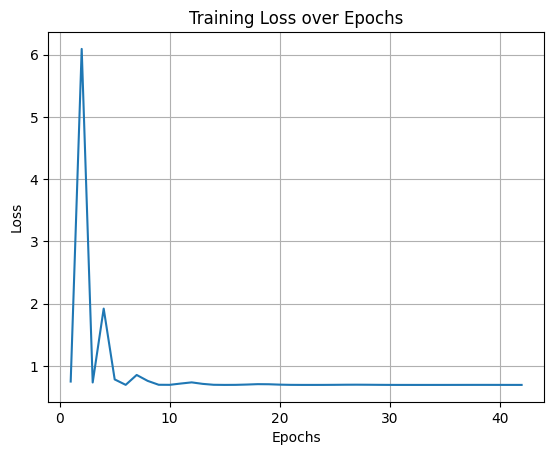

In [22]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
# plt.plot(range(1, len(list_loss) + 1), np.log(list_loss)) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

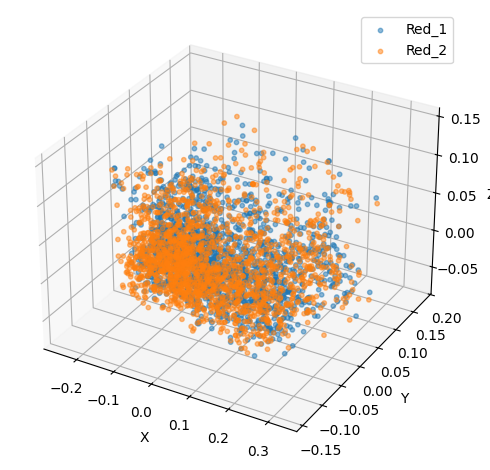

In [23]:
# Node embeddings 3D

if node_embeddings_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	node_embeddings_cat_3d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_3d = node_embeddings_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		node_embeddings_cat_3d[:, 0][labels == c],
		node_embeddings_cat_3d[:, 1][labels == c], 
		node_embeddings_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

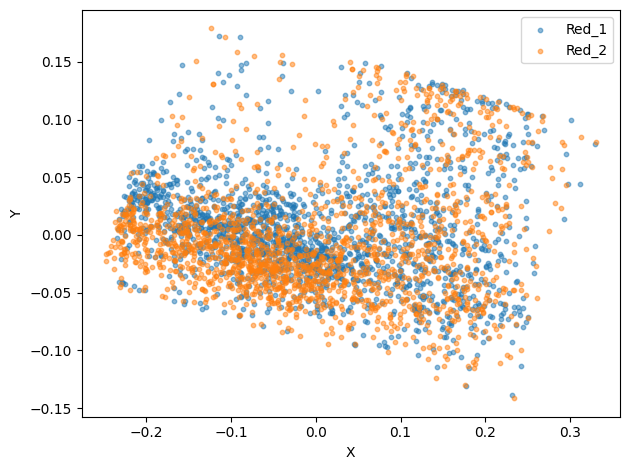

In [24]:
# Node embeddings 2D

if node_embeddings_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	node_embeddings_cat_2d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_2d = node_embeddings_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		node_embeddings_cat_2d[idx, 0],
		node_embeddings_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
plt.show()

### Similarity analysis (KNN)

In [25]:
train_set

['Red_1', 'Red_2']

In [26]:
# Get node ids

dict_node_id = {}

if dataset in ["vanessa_05", "mentos_05"]:
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx,id,mz,rt,intensity_mean,intensity_cv

		dict_node_id[ts] = df_nodes["id"].values
else:
	for ts in train_set:
		dict_node_id[ts] = np.arange(len(dict_node_embeddings[ts]))
dict_node_id

{'Red_1': array([  13,   24,   33, ..., 2301, 2304, 2306]),
 'Red_2': array([  13,   14,   24, ..., 2185, 2225, 2277])}

In [27]:
# Calculate distance matrix (KNN)

k = 1 # Change
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

first_ts = train_set[0]
x = dict_node_embeddings[first_ts]

df_node_alignment = pd.DataFrame()
df_node_alignment[first_ts] = dict_node_id[first_ts]

for ts in train_set[1:]:
	y = dict_node_embeddings[ts]
	
	knn.fit(y)
	distances, indices = knn.kneighbors(x)
	
	df_node_alignment[ts] = dict_node_id[ts][indices]
df_node_alignment

,Red_1,Red_2
0,13,61
1,24,24
2,33,92
3,40,61
4,50,50
...,...,...
1772,2285,2295
1773,2295,2277
1774,2301,2271
1775,2304,2285


In [28]:
# Find node alignment 2 by 2

col1, col2 = train_set[:2] # Change
print(col1, col2)

df_node_alignment_filter = df_node_alignment[df_node_alignment.apply(lambda row: row[col1] == row[col2], axis=1)]
df_node_alignment_filter

Red_1 Red_2


,Red_1,Red_2
1,24,24
4,50,50
5,61,61
7,70,70
9,75,75
...,...,...
1760,2244,2244
1763,2252,2252
1769,2278,2278
1770,2279,2279


In [29]:
# Find node alignment for all datasets

df_node_alignment_filter = df_node_alignment[df_node_alignment.nunique(axis=1) == 1]
print(len(df_node_alignment_filter))
df_node_alignment_filter

240


,Red_1,Red_2
1,24,24
4,50,50
5,61,61
7,70,70
9,75,75
...,...,...
1760,2244,2244
1763,2252,2252
1769,2278,2278
1770,2279,2279


In [30]:
# Comparison (with test_pairs)

if dataset not in ["vanessa_05", "mentos_05"]:
	print(len(test_pairs))
	# print(test_pairs)
	# print(df_node_alignment.values)
	mask = np.array([tuple(row) in map(tuple, test_pairs) for row in df_node_alignment.values])
	df_node_alignment["mask"] = mask
	print(df_node_alignment[df_node_alignment["mask"] == True])

### Filter MS data

In [31]:
common_node_id = df_node_alignment_filter.iloc[:, 0].values
common_node_id

array([  24,   50,   61,   70,   75,  110,  122,  132,  142,  144,  150,
        200,  214,  263,  265,  274,  279,  283,  297,  307,  323,  344,
        392,  404,  413,  439,  449,  461,  468,  478,  489,  495,  501,
        610,  612,  642,  653,  673,  675,  687,  695,  725,  737,  747,
        748,  766,  799,  804,  808,  809,  828,  839,  844,  881,  901,
        939,  950,  954, 1017, 1021, 1054, 1059, 1062, 1086, 1091, 1094,
       1100, 1130, 1131, 1138, 1143, 1148, 1176, 1201, 1210, 1239, 1253,
       1274, 1302, 1310, 1350, 1354, 1375, 1392, 1396, 1408, 1432, 1437,
       1443, 1474, 1507, 1516, 1531, 1560, 1563, 1564, 1572, 1586, 1600,
       1620, 1640, 1647, 1668, 1680, 1704, 1728, 1732, 1768, 1779, 1797,
       1801, 1843, 1846, 1849, 1868, 1893, 1907, 1931, 1933, 1938, 1941,
       1971, 1975, 2021, 2033, 2040, 2044, 2053, 2068, 2072, 2083, 2084,
       2087, 2107, 2114, 2121, 2134, 2191, 2194, 2208, 2216, 2226, 2248,
       2266, 2271, 2296,   92,  119,  227,  311,  3

In [32]:
# Read raw data

df_join_raw = pd.read_csv("data/{}/raw.csv".format(dataset), index_col=0)
df_join_raw

,Average Rt,Average Mz,Metabolite name,Blank_2.2,Blank_2.3,Blank_2.4,Blank_2.5,Blank_2.6,Blank_2.7,Blank_2.8,...,Red_2.2,Red_2.3,Orange_1.1,Orange_1.2,Orange_1.3,Orange_2.1,Orange_2.2,Orange_2.3,Blank_1.1,Blank_2.1
4,0.767,353.94570,Unknown,8.253400e-01,9.200000e-06,0.000009,9.200000e-06,9.200000e-06,9.200000e-06,0.000009,...,0.000009,9.200000e-06,0.000009,9.200000e-05,0.000009,6.888500e-01,0.000009,9.200000e-06,14499.11,2.265930e+04
13,0.849,77.12775,Unknown,1.387898e+05,8.624046e+04,72342.450000,1.051718e+05,1.057505e+05,9.259037e+04,117097.500000,...,82741.240000,7.053877e+04,207908.600000,1.581832e+05,120187.200000,9.076510e+04,89014.010000,1.132883e+05,238760.10,9.052885e+04
14,0.862,45.97014,Unknown,6.765457e+04,8.858592e+04,62918.100000,6.450759e+04,9.565974e+04,3.624424e+05,55364.950000,...,171163.700000,4.818176e+05,108095.600000,1.362666e+04,14977.210000,8.767414e+04,124921.300000,1.537605e+04,139203.70,1.000444e+05
24,0.992,109.10390,Unknown,2.234586e+04,2.257770e+04,25630.570000,6.198678e+04,2.216297e+04,3.976091e+04,48250.450000,...,29739.320000,2.090890e+04,10700.320000,4.117690e+03,5520.715000,2.248320e+04,29960.300000,2.081087e+05,106600.00,2.502775e+04
28,1.007,132.12760,Unknown,2.393976e+01,5.186566e+04,3109.359000,6.929501e+03,8.732821e+03,6.296857e+03,21127.380000,...,11475.910000,1.632536e+04,1187.276000,6.521130e+03,3848.260000,2.607996e+04,13962.350000,2.855882e+04,57370.48,3.279362e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,33.631,83.09895,Unknown,2.610749e+05,3.069017e+05,215637.400000,1.398896e+05,1.307836e+05,1.752427e+05,191386.700000,...,299743.400000,2.274897e+05,14049.380000,4.142575e+04,36417.310000,9.815955e+04,161472.700000,2.311965e+05,1397670.00,1.789797e+05
2303,33.653,457.39230,Unknown,1.000000e-07,1.000000e-07,0.000004,1.000000e-07,1.000000e-07,1.000000e-07,0.000001,...,5477.928000,1.000000e-07,17335.640000,1.000000e-07,3668.895000,1.000000e-07,1243.702000,1.000000e-07,51166.44,1.000000e-07
2304,33.666,105.09980,Unknown,4.961273e+04,9.736624e+04,109105.300000,1.165776e+05,1.079196e+05,9.511641e+04,141866.500000,...,139319.000000,1.264424e+05,81152.250000,1.082530e+05,99531.660000,1.189775e+05,198119.500000,1.690732e+05,631228.90,1.729256e+05
2305,33.673,93.09473,Unknown,1.337628e+05,1.239729e+05,91317.910000,9.673636e+04,9.306306e+04,1.107218e+05,122202.900000,...,99013.660000,7.839004e+04,59013.780000,1.218907e+05,142875.100000,2.201098e+05,217304.100000,1.155046e+05,1107215.00,5.177241e+04


In [33]:
print(len(common_node_id), len(df_join_raw))

240 1782


In [34]:
df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1, 2]]
df_join_raw_filter.to_csv(f"data/{dataset}/output/node_alignment.csv", sep=";", decimal=",", index_label="Id")
df_join_raw_filter

,Average Rt,Average Mz,Metabolite name
24,0.992,109.10390,Unknown
50,1.230,74.28162,Unknown
61,1.314,75.06935,Malate
70,1.438,463.54140,Unknown
75,1.453,45.96042,Unknown
...,...,...,...
2244,33.208,355.05510,Unknown
2252,33.274,333.95880,Unknown
2278,33.469,441.32800,Unknown
2279,33.473,243.29970,Unknown


In [35]:
# Comparison (sta vs Van)

list_node_id_sta = [39, 52, 70, 79, 94, 91, 90, 116, 123, 126, 127, 159, 157, 160, 175, 188, 190, 189, 173, 205, 202, 211, 212]

match = set(list_node_id_sta) & set(common_node_id)
print(train_set)
print(f"Alignment: {len(common_node_id)} / {len(df_join_raw)}")
print(f"Match comp: {len(match)}/{len(list_node_id_sta)}")
print(match)

['Red_1', 'Red_2']
Alignment: 240 / 1782
Match comp: 1/23
{70}


### Clustering analysis

In [36]:
df_join_raw

,Average Rt,Average Mz,Metabolite name,Blank_2.2,Blank_2.3,Blank_2.4,Blank_2.5,Blank_2.6,Blank_2.7,Blank_2.8,...,Red_2.2,Red_2.3,Orange_1.1,Orange_1.2,Orange_1.3,Orange_2.1,Orange_2.2,Orange_2.3,Blank_1.1,Blank_2.1
4,0.767,353.94570,Unknown,8.253400e-01,9.200000e-06,0.000009,9.200000e-06,9.200000e-06,9.200000e-06,0.000009,...,0.000009,9.200000e-06,0.000009,9.200000e-05,0.000009,6.888500e-01,0.000009,9.200000e-06,14499.11,2.265930e+04
13,0.849,77.12775,Unknown,1.387898e+05,8.624046e+04,72342.450000,1.051718e+05,1.057505e+05,9.259037e+04,117097.500000,...,82741.240000,7.053877e+04,207908.600000,1.581832e+05,120187.200000,9.076510e+04,89014.010000,1.132883e+05,238760.10,9.052885e+04
14,0.862,45.97014,Unknown,6.765457e+04,8.858592e+04,62918.100000,6.450759e+04,9.565974e+04,3.624424e+05,55364.950000,...,171163.700000,4.818176e+05,108095.600000,1.362666e+04,14977.210000,8.767414e+04,124921.300000,1.537605e+04,139203.70,1.000444e+05
24,0.992,109.10390,Unknown,2.234586e+04,2.257770e+04,25630.570000,6.198678e+04,2.216297e+04,3.976091e+04,48250.450000,...,29739.320000,2.090890e+04,10700.320000,4.117690e+03,5520.715000,2.248320e+04,29960.300000,2.081087e+05,106600.00,2.502775e+04
28,1.007,132.12760,Unknown,2.393976e+01,5.186566e+04,3109.359000,6.929501e+03,8.732821e+03,6.296857e+03,21127.380000,...,11475.910000,1.632536e+04,1187.276000,6.521130e+03,3848.260000,2.607996e+04,13962.350000,2.855882e+04,57370.48,3.279362e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,33.631,83.09895,Unknown,2.610749e+05,3.069017e+05,215637.400000,1.398896e+05,1.307836e+05,1.752427e+05,191386.700000,...,299743.400000,2.274897e+05,14049.380000,4.142575e+04,36417.310000,9.815955e+04,161472.700000,2.311965e+05,1397670.00,1.789797e+05
2303,33.653,457.39230,Unknown,1.000000e-07,1.000000e-07,0.000004,1.000000e-07,1.000000e-07,1.000000e-07,0.000001,...,5477.928000,1.000000e-07,17335.640000,1.000000e-07,3668.895000,1.000000e-07,1243.702000,1.000000e-07,51166.44,1.000000e-07
2304,33.666,105.09980,Unknown,4.961273e+04,9.736624e+04,109105.300000,1.165776e+05,1.079196e+05,9.511641e+04,141866.500000,...,139319.000000,1.264424e+05,81152.250000,1.082530e+05,99531.660000,1.189775e+05,198119.500000,1.690732e+05,631228.90,1.729256e+05
2305,33.673,93.09473,Unknown,1.337628e+05,1.239729e+05,91317.910000,9.673636e+04,9.306306e+04,1.107218e+05,122202.900000,...,99013.660000,7.839004e+04,59013.780000,1.218907e+05,142875.100000,2.201098e+05,217304.100000,1.155046e+05,1107215.00,5.177241e+04


In [37]:
df_join_raw_signal = df_join_raw.loc[common_node_id].iloc[:, 3:-2] # Important two last column no only to Mentos
df_join_raw_signal

,Blank_2.2,Blank_2.3,Blank_2.4,Blank_2.5,Blank_2.6,Blank_2.7,Blank_2.8,Blank_2.9,Blank_2.10,QC_1.1,...,Red_1.3,Red_2.1,Red_2.2,Red_2.3,Orange_1.1,Orange_1.2,Orange_1.3,Orange_2.1,Orange_2.2,Orange_2.3
24,2.234586e+04,2.257770e+04,2.563057e+04,6.198678e+04,2.216297e+04,39760.910000,4.825045e+04,2.275505e+04,7.521755e+03,30928.950000,...,2.858363e+03,4.369223e+04,2.973932e+04,2.090890e+04,10700.32000,4.117690e+03,5.520715e+03,2.248320e+04,2.996030e+04,2.081087e+05
50,1.117319e+05,2.087352e+04,5.358594e+04,5.661241e+04,3.210332e+04,54462.460000,7.006790e+04,9.935264e+04,2.843490e+05,47612.410000,...,2.735881e+04,4.394762e+04,4.510232e+04,3.730376e+04,13721.71000,3.569638e+04,1.254843e+04,9.079319e+04,2.192714e+04,8.177053e+04
61,6.838904e+04,8.767080e+04,4.867510e+04,8.365231e+04,4.677586e+04,39651.950000,1.922883e+05,1.625830e+05,2.473232e+04,62232.180000,...,5.795915e+02,6.727489e+04,6.438280e+04,9.087448e+04,2180.50400,1.979294e+03,1.433922e+03,4.514196e+04,5.897684e+04,4.024575e+05
70,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,0.000004,4.300000e-06,4.300000e-06,4.300000e-06,0.000004,...,4.300000e-06,4.300000e-06,4.300000e-06,1.762100e-01,11096.68000,4.929900e-01,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06
75,1.353961e+04,1.814541e+04,3.171124e+04,5.172908e+04,8.442326e+04,118932.200000,1.017870e+05,3.085272e+05,1.063435e+05,121546.600000,...,6.712958e+04,2.471184e+06,4.272335e+05,7.050055e+04,231933.10000,4.820107e+05,9.410941e+05,8.534082e+04,1.982255e+05,1.095165e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,8.579747e+04,3.960441e+04,3.442523e+04,3.666095e+04,4.508574e+04,93741.070000,5.329566e+04,4.915778e+04,2.670038e+04,89728.800000,...,1.584324e+04,1.222257e+05,7.515423e+04,7.342340e+04,10936.51000,1.148801e+04,1.490427e+04,7.520951e+04,1.007178e+05,7.653157e+04
2252,1.121980e+00,1.170000e-03,4.170000e-05,7.620000e-06,2.510000e-07,0.000016,2.510000e-07,2.510000e-07,2.510000e-07,0.170320,...,3.010000e-06,2.510000e-07,2.510000e-07,2.510000e-06,0.01768,2.776000e-02,9.190000e-03,5.820000e-03,2.510000e-07,2.510000e-07
2278,4.420000e-15,4.420000e-15,2.340000e-12,4.420000e-15,4.420000e-15,532.857600,3.490000e-06,4.420000e-15,4.420000e-15,0.000050,...,4.420000e-15,4.420000e-15,1.243900e-01,4.420000e-15,0.00002,5.280000e-07,4.420000e-14,4.420000e-15,4.420000e-15,4.420000e-15
2279,1.122618e+04,1.819430e+04,2.471490e+00,4.906000e-02,3.183350e+01,0.000640,8.529416e+03,5.039000e-02,9.750000e-07,8697.033000,...,3.159986e+04,1.079094e+03,6.548785e+01,1.335000e-02,54757.05000,7.828600e+00,3.402727e+04,6.019308e+03,2.089000e-02,2.767819e+04


In [38]:
df_join_raw_signal_t = df_join_raw_signal.T
df_join_raw_signal_t

,24,50,61,70,75,110,122,132,142,144,...,2144,2171,2190,2201,2209,2244,2252,2278,2279,2284
Blank_2.2,22345.8600,111731.90,68389.0400,0.000004,13539.61,107326.20,81211.75,43461.51,97228.00,1.910000e-07,...,127390.10,78622.0200,270040.8,113654.90,268913.30,85797.470,1.121980e+00,4.420000e-15,1.122618e+04,84674.11
Blank_2.3,22577.7000,20873.52,87670.8000,0.000004,18145.41,89265.46,54571.65,93830.98,86960.34,4.300000e-04,...,110925.80,52776.3200,318409.9,110837.00,134088.50,39604.410,1.170000e-03,4.420000e-15,1.819430e+04,43056.38
Blank_2.4,25630.5700,53585.94,48675.1000,0.000004,31711.24,72997.93,25063.74,62275.50,149093.60,1.910000e-07,...,120511.90,102486.7000,355060.9,164942.90,146533.60,34425.230,4.170000e-05,2.340000e-12,2.471490e+00,49335.08
Blank_2.5,61986.7800,56612.41,83652.3100,0.000004,51729.08,182151.60,45990.80,65752.79,156834.10,1.910000e-07,...,150150.20,81510.1600,300492.0,128992.00,191113.60,36660.950,7.620000e-06,4.420000e-15,4.906000e-02,86135.94
Blank_2.6,22162.9700,32103.32,46775.8600,0.000004,84423.26,89920.22,34609.28,42226.36,94242.02,4.796534e+01,...,120599.00,56847.1800,324189.7,86312.03,78837.85,45085.740,2.510000e-07,4.420000e-15,3.183350e+01,113300.10
Blank_2.7,39760.9100,54462.46,39651.9500,0.000004,118932.20,118711.50,77792.18,59887.25,79815.84,9.717247e+03,...,101216.70,63477.4100,185686.0,142809.40,145221.90,93741.070,1.630000e-05,5.328576e+02,6.400000e-04,120843.50
Blank_2.8,48250.4500,70067.90,192288.3000,0.000004,101787.00,79766.50,44679.65,64170.58,134621.30,1.910000e-06,...,76984.95,54951.9300,199518.0,96166.65,68193.91,53295.660,2.510000e-07,3.490000e-06,8.529416e+03,77491.66
Blank_2.9,22755.0500,99352.64,162583.0000,0.000004,308527.20,102040.90,30080.25,86291.80,70788.15,1.910000e-07,...,75211.80,36383.5600,96972.8,39622.59,44648.25,49157.780,2.510000e-07,4.420000e-15,5.039000e-02,26887.06
Blank_2.10,7521.7550,284349.00,24732.3200,0.000004,106343.50,219567.70,12370.58,304263.90,151238.40,1.910000e-07,...,63011.84,67953.7700,209232.6,168900.70,20837.02,26700.380,2.510000e-07,4.420000e-15,9.750000e-07,113296.00
QC_1.1,30928.9500,47612.41,62232.1800,0.000004,121546.60,899055.30,82448.25,235417.90,143057.30,8.625794e+03,...,110134.00,96724.3100,325007.4,112057.40,195446.70,89728.800,1.703200e-01,5.000000e-05,8.697033e+03,136423.40


In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_join_raw_signal_t.values)
X_scaled

array([[-0.30579038,  0.8598039 , -0.00790492, ..., -0.17154002,
         0.03243052, -0.30699573],
       [-0.30105649, -0.64339306,  0.24343986, ..., -0.17154002,
         0.51316547, -0.71412122],
       [-0.23872055, -0.10218585, -0.26488332, ..., -0.17154002,
        -0.74190014, -0.65269983],
       ...,
       [-0.30298606,  0.5133856 , -0.31093909, ..., -0.17154002,
        -0.32679483, -0.12161547],
       [-0.15031266, -0.62596156, -0.13059638, ..., -0.17154002,
        -0.74206921, -0.52516634],
       [ 3.48726385,  0.36411115,  4.34679935, ..., -0.17154002,
         1.16746497, -0.18795247]])

In [40]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[  8.0840477 ,  -2.99167048],
       [  1.3572389 ,  -4.33001174],
       [  0.53744293,  -4.93025234],
       [  0.43669051,  -5.23395687],
       [ -0.60057091,  -5.78000796],
       [  1.60517741,  -5.43896456],
       [  1.84604314,  -4.49694856],
       [ -3.17289206,  -6.90434753],
       [ -4.49104239,  -7.77553642],
       [  8.097233  ,   4.55906629],
       [  8.09723281,   4.55906612],
       [ 10.69142049,   5.50636825],
       [  7.08589882,   5.47163952],
       [  8.82554415,   3.76249321],
       [  7.89515621,   4.30708029],
       [  8.40218335,   4.53894468],
       [  1.53238306,  -6.61860853],
       [-10.70604118,   4.62885044],
       [-12.59283914,   7.27750027],
       [-13.49237576,   7.49865722],
       [  3.56463715,  -1.36673889],
       [  2.21217539,  -1.72109557],
       [  5.15600433,  -1.96040974],
       [-12.80765386,  -2.97388022],
       [-13.13632017,  -3.58769117],
       [-13.35390047,  -1.86406303],
       [  7.21416744,   0.56526362],
 

In [41]:
labels = [item.split("_")[0] for item in df_join_raw_signal_t.index]
labels

['Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'QC',
 'QC',
 'QC',
 'QC',
 'QC',
 'QC',
 'QC',
 'Std',
 'Yellow',
 'Yellow',
 'Yellow',
 'Yellow',
 'Yellow',
 'Yellow',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Orange',
 'Orange',
 'Orange',
 'Orange',
 'Orange',
 'Orange']

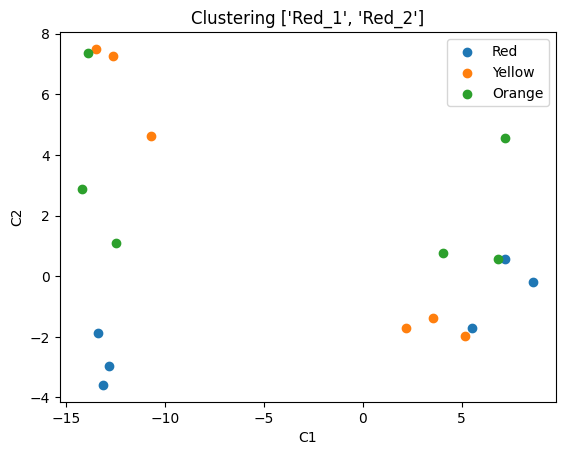

In [42]:
x, y = X_pca[:, 0], X_pca[:, 1]

unique_groups = ["Red", "Yellow", "Orange"] # np.unique(labels)

for group in unique_groups:
	xi = [x[i] for i in range(len(x)) if labels[i] == group]
	yi = [y[i] for i in range(len(y)) if labels[i] == group]
	plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.show()

In [43]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=3).fit_transform(X_scaled)

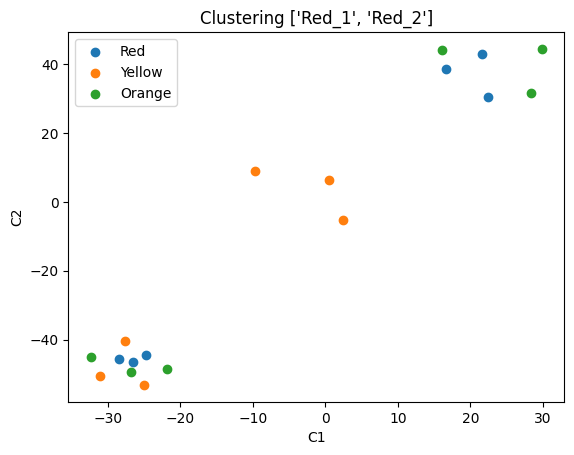

In [44]:
x, y = X_tsne[:, 0], X_tsne[:, 1]

unique_groups = ["Red", "Yellow", "Orange"] # np.unique(labels)

for group in unique_groups:
	xi = [x[i] for i in range(len(x)) if labels[i] == group]
	yi = [y[i] for i in range(len(y)) if labels[i] == group]
	plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.show()

In [45]:
# import torch
# print(torch.cuda.memory_summary())